# **Prueba Data Scientist Habi**

---



## **Antes de empezar**, por favor guarde este notebook como una copia personal, para no editar la versión original de esta. Esto lo puede hacer en File->Save a copy in Drive

## **Punto 1**


---



Descargar base de datos de UPLs (subdivisión urbana para Bogotá) y de inmuebles, todo con código. Es decir, utilizando las librerías necesarias para extraer datos desde internet sin necesidad de leerlos de manera local. Sugerimos la librería urllib.

* UPLs: 'https://datosabiertos.bogota.gov.co/dataset/808582fc-ffc8-4649-8428-7e1fd8d3820c/resource/a5c8c591-0708-420f-8eb7-9f3147e21c40/download/unidadplaneamientolocal.json'
* Inmuebles: 'https://storage.googleapis.com/pruebas-data-analitica/inmuebles_full.csv.gz'

Esta segunda tabla tiene información de inmuebles publicados en páginas web.



In [70]:
"""
Escriba aquí su código. De ser necesario, puede agregar más celdas.
"""


'\nEscriba aquí su código. De ser necesario, puede agregar más celdas.\n'

### Install Libraries

In [71]:
# Install the Libraries
# !pip install keplergl
# !pip install -q ipyleaflet
# !pip install pandas
# !pip install geopandas

### Import Libraries

In [72]:
# Libraries Required
from esda.moran import Moran, Moran_Local
import geopandas as gpd
import gzip
import io
import json
from keplergl import KeplerGl
from libpysal.weights import Queen
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import seaborn as sns
from shapely.geometry import Polygon, MultiPolygon
from splot.esda import plot_moran, moran_scatterplot, lisa_cluster, plot_local_autocorrelation
import traceback
from urllib.request import urlopen
import zipfile

### Read UPLs

#### Nota:

Cada uno de los archivos se descargó y leyó únicamente con código. Sin embargo, dado que la descarga tomaba bastante tiempo con archivos superando 1 GB de memoria una vez descargados los archivos se descargaron localmente para ahorrar los tiempos de descarga y solo leer desde memoria.

A pesar de estas medidas, el código comentado en la siguiente celda es funcional y fue la manera en que se descargaron y leyeron los archivos originalmente.

In [73]:
# Time: 5 seconds
# # Url
# url_upls = 'https://datosabiertos.bogota.gov.co/dataset/808582fc-ffc8-4649-8428-7e1fd8d3820c/resource/a5c8c591-0708-420f-8eb7-9f3147e21c40/download/unidadplaneamientolocal.json'

# # Request
# response_upls = urlopen(url_upls)

# # Check the status of the request (200 = Works)
# status_response_upls = response_upls.status
# assert(status_response_upls == 200)

# # Read the file
# file_upls = response_upls.read()
# print(type(file_upls))

# # Convert from bytes to str
# string_upls = file_upls.decode()
# print(type(string_upls))

# # Conver from str to dict
# dict_upls = json.loads(string_upls)
# print(type(dict_upls))

# # Check the type is dict so it can be accessed easily
# assert(type(dict_upls) == dict)

In [74]:
# Time: 0.1 seconds
with open('Data/unidadplaneamientolocal.json') as file:
    dict_upls = dict(json.load(file))

In [75]:
# Print the different keys in the dict and the type of value of each key
for key, value in dict_upls.items():
  print(f'{key}: {type(value)}')

displayFieldName: <class 'str'>
fieldAliases: <class 'dict'>
geometryType: <class 'str'>
spatialReference: <class 'dict'>
fields: <class 'list'>
features: <class 'list'>


In [76]:
# Create a geodataframe with the rows of the file
# Since it is a json create the dataframe with a list of dicts
list_rows = []

# The data is int the features key, where each row is a list
for row in dict_upls['features']:
  
  # Get the attributes (columns of the dataframe)
  attributes = row['attributes']
  
  # Conver the geometry to a polygon
  geometry = row['geometry']  
  coordinates = geometry['rings'][0]
  polygon = Polygon(coordinates)  
  
  # Add the polygon to the attributes with the key 'geometry'
  attributes['geometry'] = polygon

  # Add the dict of the row to the list of dicts
  list_rows.append(attributes)

# Clear the memory of the variable
del dict_upls

# Create the GeoDataFrame
df_upls = gpd.GeoDataFrame(
    list_rows,
    geometry='geometry'
)

# Change the column names to lowercase (just a toc)
df_upls.columns = [column.lower() for column in (df_upls.columns)]

# Keep only the columns needed
list_columns_to_keep = [
    'codigo_upl',
    'nombre',
    'vocacion',
    'sector',
    'geometry',
]
df_upls = df_upls[list_columns_to_keep]

In [77]:
df_upls.head()

,codigo_upl,nombre,vocacion,sector,geometry
0,UPL13,Tintal,Urbano-Rural,Sector Sur Occidente,"POLYGON ((-74.16957 4.65632, -74.16955 4.65631..."
1,UPL30,Salitre,Urbano,Sector Occidente,"POLYGON ((-74.09471 4.66478, -74.10058 4.65718..."
2,UPL22,Restrepo,Urbano,Sector Centro Ampliado,"POLYGON ((-74.10459 4.56467, -74.10468 4.56482..."
3,UPL31,Puente Aranda,Urbano,Sector Centro Ampliado,"POLYGON ((-74.08320 4.62470, -74.08400 4.62371..."
4,UPL32,Teusaquillo,Urbano,Sector Centro Ampliado,"POLYGON ((-74.07160 4.61775, -74.07283 4.61542..."


In [78]:
df_upls.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   codigo_upl  33 non-null     object  
 1   nombre      33 non-null     object  
 2   vocacion    33 non-null     object  
 3   sector      33 non-null     object  
 4   geometry    33 non-null     geometry
dtypes: geometry(1), object(4)
memory usage: 1.4+ KB


### Read Inmuebles

#### Nota:

Cada uno de los archivos se descargó y leyó únicamente con código. Sin embargo, dado que la descarga tomaba bastante tiempo con archivos superando 1 GB de memoria una vez descargados los archivos se descargaron localmente para ahorrar los tiempos de descarga y solo leer desde memoria.

A pesar de estas medidas, el código comentado en la siguiente celda es funcional y fue la manera en que se descargaron y leyeron los archivos originalmente.

In [79]:
# Time: 6 seconds
# # Url
# url_inmuebles = 'https://storage.googleapis.com/pruebas-data-analitica/inmuebles_full.csv.gz'

# # Request
# response_inmuebles = urlopen(url_inmuebles)

# # Check the status of the request (200 = Works)
# status_response_inmuebles = response_inmuebles.status
# assert(status_response_inmuebles == 200)

# # Since it is a zipped file we need decompress it
# gzip_file = gzip.GzipFile(fileobj=response_inmuebles)
# print(type(gzip_file))

# # Read the unzipped file
# file_inmuebles = gzip_file.read()
# print(type(file_inmuebles))

# # Convert from bytes to str
# string_inmuebles = file_inmuebles.decode()
# print(type(string_inmuebles))

# # 'Save' in memory the file and then read it as a traditional csv file
# csv_inmuebles = io.StringIO(string_inmuebles)
# df_inmuebles = pd.read_csv(csv_inmuebles)
# print(type(df_inmuebles))

# # Check the type is DataFrame
# assert(isinstance(df_inmuebles, pd.DataFrame))

In [80]:
# Time: 4 seconds
df_inmuebles = pd.read_csv('Data/inmuebles_full.csv')

In [81]:
df_inmuebles['geometry'] = gpd.points_from_xy(x=df_inmuebles['longitud'], y=df_inmuebles['latitud'])
df_inmuebles.drop(['latitud', 'longitud'], axis=1, inplace=True)
df_inmuebles = gpd.GeoDataFrame(df_inmuebles, geometry='geometry')

In [82]:
df_inmuebles.head()

,id,fecha_creacion,departamento,municipio,habitaciones,banos,area,precio,num_ascensores,garajes,direccion,anos_antiguedad,tipo_inmueble,tiponegocio,geometry
0,3669162,2022-03-02,VALLE DEL CAUCA,CALI,3.0,2,81.0,2.640000e+08,0,1,Carrera 99A # 45 - 200 Apto 706 Torre 3 Lili d...,12,apartamento,venta,POINT (-76.49500 3.36400)
1,3067524,2021-12-12,ANTIOQUIA,SABANETA,2.0,3,90.0,4.600000e+08,1,2,Calle 70A SUR # 35 - 340 Apto 3402 Urbanizacio...,4,apartamento,venta,POINT (-75.60200 6.14300)
2,3944108,2022-03-18,CUNDINAMARCA,CAJICÁ,3.0,4,140.0,1.000000e+09,0,4,abaco,4,casa,venta,POINT (-74.04343 4.89866)
3,500215,2020-07-23,ANTIOQUIA,RIONEGRO,3.0,2,75.0,1.600000e+06,0,1,CALLE 32 52B- 150,1,apartamento,arriendo,POINT (-75.42595 6.12084)
4,741346,2020-09-15,CUNDINAMARCA,SOPÓ,4.0,5,750.0,3.300000e+09,0,6,AUTOPISTA NORTE KM 33,12,casa,venta,POINT (-73.98262 4.93952)


In [83]:
df_inmuebles.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 882888 entries, 0 to 882887
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype   
---  ------           --------------   -----   
 0   id               882888 non-null  int64   
 1   fecha_creacion   882888 non-null  object  
 2   departamento     882888 non-null  object  
 3   municipio        882888 non-null  object  
 4   habitaciones     882147 non-null  float64 
 5   banos            882888 non-null  int64   
 6   area             882888 non-null  float64 
 7   precio           860683 non-null  float64 
 8   num_ascensores   882888 non-null  int64   
 9   garajes          882888 non-null  int64   
 10  direccion        882664 non-null  object  
 11  anos_antiguedad  882888 non-null  int64   
 12  tipo_inmueble    882888 non-null  object  
 13  tiponegocio      882888 non-null  object  
 14  geometry         882888 non-null  geometry
dtypes: float64(3), geometry(1), int64(5), object(6)
memory usage

## **Punto 2**

---



Hacer un join espacial entre la base de datos de UPLs e inmuebles y
calcular cuántas ofertas inmobiliarias existen en Bogotá por UPL. Para esto sugerimos usar la librería de GeoPandas.

In [84]:
"""
Escriba aquí su código. De ser necesario, puede agregar más celdas.
"""

'\nEscriba aquí su código. De ser necesario, puede agregar más celdas.\n'

### Join Inmuebles + UPLs

In [85]:
# Get the upl that belongs to each inmueble (mostly Bogotá)
df_inmuebles = gpd.sjoin(
    df_inmuebles, 
    df_upls[['codigo_upl', 'geometry']],
    how='left',
    predicate='within'
)
df_inmuebles['precio_m2'] = df_inmuebles['precio'] / df_inmuebles['area'] / 1000000

In [86]:
df_inmuebles.head()

,id,fecha_creacion,departamento,municipio,habitaciones,banos,area,precio,num_ascensores,garajes,direccion,anos_antiguedad,tipo_inmueble,tiponegocio,geometry,index_right,codigo_upl,precio_m2
0,3669162,2022-03-02,VALLE DEL CAUCA,CALI,3.0,2,81.0,2.640000e+08,0,1,Carrera 99A # 45 - 200 Apto 706 Torre 3 Lili d...,12,apartamento,venta,POINT (-76.49500 3.36400),NaN,NaN,3.259259
1,3067524,2021-12-12,ANTIOQUIA,SABANETA,2.0,3,90.0,4.600000e+08,1,2,Calle 70A SUR # 35 - 340 Apto 3402 Urbanizacio...,4,apartamento,venta,POINT (-75.60200 6.14300),NaN,NaN,5.111111
2,3944108,2022-03-18,CUNDINAMARCA,CAJICÁ,3.0,4,140.0,1.000000e+09,0,4,abaco,4,casa,venta,POINT (-74.04343 4.89866),NaN,NaN,7.142857
3,500215,2020-07-23,ANTIOQUIA,RIONEGRO,3.0,2,75.0,1.600000e+06,0,1,CALLE 32 52B- 150,1,apartamento,arriendo,POINT (-75.42595 6.12084),NaN,NaN,0.021333
4,741346,2020-09-15,CUNDINAMARCA,SOPÓ,4.0,5,750.0,3.300000e+09,0,6,AUTOPISTA NORTE KM 33,12,casa,venta,POINT (-73.98262 4.93952),NaN,NaN,4.400000


In [87]:
df_inmuebles.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 882888 entries, 0 to 882887
Data columns (total 18 columns):
 #   Column           Non-Null Count   Dtype   
---  ------           --------------   -----   
 0   id               882888 non-null  int64   
 1   fecha_creacion   882888 non-null  object  
 2   departamento     882888 non-null  object  
 3   municipio        882888 non-null  object  
 4   habitaciones     882147 non-null  float64 
 5   banos            882888 non-null  int64   
 6   area             882888 non-null  float64 
 7   precio           860683 non-null  float64 
 8   num_ascensores   882888 non-null  int64   
 9   garajes          882888 non-null  int64   
 10  direccion        882664 non-null  object  
 11  anos_antiguedad  882888 non-null  int64   
 12  tipo_inmueble    882888 non-null  object  
 13  tiponegocio      882888 non-null  object  
 14  geometry         882888 non-null  geometry
 15  index_right      364778 non-null  float64 
 16  codigo_upl       

### Ofertas por UPL

In [88]:
# Find the ofertas per UPL and sort it from higher to lower
df_ofertas_upl = df_inmuebles.groupby(['codigo_upl']).agg(ofertas=('id', 'count')).reset_index().sort_values(by='ofertas', ascending=False)

# Find the percentage and since it is sorted the cumulative percentage to check rules as Pareto
df_ofertas_upl['porcentaje'] = df_ofertas_upl['ofertas'] / df_ofertas_upl['ofertas'].sum()
df_ofertas_upl['porcentaje_acum'] = df_ofertas_upl['porcentaje'].cumsum()

# Complete the information of the UPL to graph it
df_ofertas_upl =pd.merge(
    df_ofertas_upl,
    df_upls,
    how='left',
    on='codigo_upl'
)

# Convert to geodataframe
df_ofertas_upl = gpd.GeoDataFrame(
    df_ofertas_upl,
    geometry='geometry'
)

In [89]:
df_ofertas_upl.head(10)

,codigo_upl,ofertas,porcentaje,porcentaje_acum,nombre,vocacion,sector,geometry
0,UPL25,104775,0.287229,0.287229,Usaquén,Urbano,Sector Norte,"POLYGON ((-74.02093 4.72971, -74.02106 4.72966..."
1,UPL24,61630,0.168952,0.456182,Chapinero,Urbano,Sector Centro Ampliado,"POLYGON ((-74.05651 4.64143, -74.05650 4.64143..."
2,UPL27,34948,0.095806,0.551988,Niza,Urbano,Sector Norte,"POLYGON ((-74.07828 4.73386, -74.07750 4.73341..."
3,UPL08,27014,0.074056,0.626044,Britalia,Urbano-Rural,Sector Norte,"POLYGON ((-74.06328 4.77114, -74.06327 4.77114..."
4,UPL32,17935,0.049167,0.675211,Teusaquillo,Urbano,Sector Centro Ampliado,"POLYGON ((-74.07160 4.61775, -74.07283 4.61542..."
5,UPL30,15419,0.042270,0.717480,Salitre,Urbano,Sector Occidente,"POLYGON ((-74.09471 4.66478, -74.10058 4.65718..."
6,UPL26,14609,0.040049,0.757529,Toberín,Urbano,Sector Norte,"POLYGON ((-74.04264 4.77101, -74.03995 4.77060..."
7,UPL33,11034,0.030249,0.787778,Barrios Unidos,Urbano,Sector Centro Ampliado,"POLYGON ((-74.06413 4.65239, -74.06463 4.64965..."
8,UPL23,10543,0.028903,0.816680,Centro Histórico,Urbano,Sector Centro Ampliado,"POLYGON ((-74.05772 4.62403, -74.05755 4.62393..."
9,UPL13,9093,0.024927,0.841608,Tintal,Urbano-Rural,Sector Sur Occidente,"POLYGON ((-74.16957 4.65632, -74.16955 4.65631..."


In [90]:
df_ofertas_upl.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   codigo_upl       33 non-null     object  
 1   ofertas          33 non-null     int64   
 2   porcentaje       33 non-null     float64 
 3   porcentaje_acum  33 non-null     float64 
 4   nombre           33 non-null     object  
 5   vocacion         33 non-null     object  
 6   sector           33 non-null     object  
 7   geometry         33 non-null     geometry
dtypes: float64(2), geometry(1), int64(1), object(4)
memory usage: 2.2+ KB


## **Punto 3**


---



Use una visualización que permita ver cuántas ofertas de inmuebles existen por UPL.

In [91]:
"""
Escriba aquí su código. De ser necesario, puede agregar más celdas.
"""

'\nEscriba aquí su código. De ser necesario, puede agregar más celdas.\n'

### Visualización Inmuebles + UPLs

#### Gráfica

In [92]:
fig = px.bar(
    df_ofertas_upl.sort_values(by='ofertas', ascending=True),
    x='ofertas',
    y='nombre',
    orientation='h',
    labels={'ofertas': 'Ofertas', 'nombre': 'Nombre UPL'},
    title='Ofertas de Inmuebles por UPL',
    # marker_
)

fig.update_layout(
    width=600,
    height=800,
)

fig.show()

#### Mapa

Para añadir la dimensión geográfica al número de ofertas por UPL, es necesario verlo a través de un mapa. Esto permite analizar patrones y tendencias a traves del espacio.
1. (**Recomendado**) Visualizar la versión desplegada en página web en [este link](https://santigonzalezz.github.io/habi_prueba_data_science/mapa_ofertas_upls.html)
1. Visualizar el mapa en las celdas siguientes, sin embargo, se encuentra limitada la interactividad y es posible errores al guardar el archivo y no ejecutar las celdas

In [93]:
# Create the map object
mapa_ofertas_upls = KeplerGl(
    height=500,
    # data={'ofertas_upl': df_ofertas_upl}
)

# Add the data of ofertas per upl
mapa_ofertas_upls.add_data(df_ofertas_upl, 'Ofertas UPL')

# Add the data of inmuebles
mapa_ofertas_upls.add_data(df_inmuebles[~df_inmuebles['codigo_upl'].isna()][['id', 'geometry']], 'Inmuebles')

# Read the config of the map as a json
# with open('Data/config_mapa_ofertas_upls.json') as file:
#     config_mapa_ofertas_upls = json.load(file)

# Read the config of the map as a json
config_mapa_ofertas_upls = json.loads(
    '{"version": "v1", "config": {"visState": {"filters": [], "layers": [{"id": "5l8szv", "type": "geojson", "config": {"dataId": "Inmuebles", "label": "Inmuebles", "color": [240, 109, 109], "highlightColor": [252, 242, 26, 255], "columns": {"geojson": "geometry"}, "isVisible": true, "visConfig": {"opacity": 0.8, "strokeOpacity": 0.8, "thickness": 0, "strokeColor": null, "colorRange": {"name": "Global Warming", "type": "sequential", "category": "Uber", "colors": ["#5A1846", "#900C3F", "#C70039", "#E3611C", "#F1920E", "#FFC300"]}, "strokeColorRange": {"name": "Global Warming", "type": "sequential", "category": "Uber", "colors": ["#5A1846", "#900C3F", "#C70039", "#E3611C", "#F1920E", "#FFC300"]}, "radius": 1.5, "sizeRange": [0, 10], "radiusRange": [0, 50], "heightRange": [0, 500], "elevationScale": 5, "enableElevationZoomFactor": true, "stroked": false, "filled": true, "enable3d": false, "wireframe": false}, "hidden": false, "textLabel": [{"field": null, "color": [255, 255, 255], "size": 18, "offset": [0, 0], "anchor": "start", "alignment": "center"}]}, "visualChannels": {"colorField": null, "colorScale": "quantile", "strokeColorField": null, "strokeColorScale": "quantile", "sizeField": null, "sizeScale": "linear", "heightField": null, "heightScale": "linear", "radiusField": null, "radiusScale": "linear"}}, {"id": "zfp3c9d", "type": "geojson", "config": {"dataId": "Ofertas UPL", "label": "Ofertas UPL", "color": [18, 147, 154], "highlightColor": [252, 242, 26, 255], "columns": {"geojson": "geometry"}, "isVisible": true, "visConfig": {"opacity": 0.8, "strokeOpacity": 0.8, "thickness": 0.5, "strokeColor": [221, 178, 124], "colorRange": {"name": "ColorBrewer Blues-9", "type": "singlehue", "category": "ColorBrewer", "colors": ["#f7fbff", "#deebf7", "#c6dbef", "#9ecae1", "#6baed6", "#4292c6", "#2171b5", "#08519c", "#08306b"]}, "strokeColorRange": {"name": "Global Warming", "type": "sequential", "category": "Uber", "colors": ["#5A1846", "#900C3F", "#C70039", "#E3611C", "#F1920E", "#FFC300"]}, "radius": 10, "sizeRange": [0, 10], "radiusRange": [0, 50], "heightRange": [0, 500], "elevationScale": 5, "enableElevationZoomFactor": true, "stroked": true, "filled": true, "enable3d": false, "wireframe": false}, "hidden": false, "textLabel": [{"field": null, "color": [255, 255, 255], "size": 18, "offset": [0, 0], "anchor": "start", "alignment": "center"}]}, "visualChannels": {"colorField": {"name": "ofertas", "type": "integer"}, "colorScale": "quantile", "strokeColorField": null, "strokeColorScale": "quantile", "sizeField": null, "sizeScale": "linear", "heightField": null, "heightScale": "linear", "radiusField": null, "radiusScale": "linear"}}], "interactionConfig": {"tooltip": {"fieldsToShow": {"Ofertas UPL": [{"name": "codigo_upl", "format": null}, {"name": "ofertas", "format": null}, {"name": "porcentaje", "format": null}, {"name": "porcentaje_acum", "format": null}, {"name": "nombre", "format": null}], "Inmuebles": [{"name": "id", "format": null}]}, "compareMode": false, "compareType": "absolute", "enabled": true}, "brush": {"size": 0.5, "enabled": false}, "geocoder": {"enabled": false}, "coordinate": {"enabled": false}}, "layerBlending": "normal", "splitMaps": [], "animationConfig": {"currentTime": null, "speed": 1}}, "mapState": {"bearing": 0, "dragRotate": false, "latitude": 4.645019643007336, "longitude": -74.10667522580201, "pitch": 0, "zoom": 9.887221846798692, "isSplit": false}, "mapStyle": {"styleType": "dark", "topLayerGroups": {}, "visibleLayerGroups": {"label": true, "road": true, "border": false, "building": true, "water": true, "land": true, "3d building": false}, "threeDBuildingColor": [9.665468314072013, 17.18305478057247, 31.1442867897876], "mapStyles": {}}}}'
)

# Set the configuration to the map
mapa_ofertas_upls.config = config_mapa_ofertas_upls

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


In [94]:
# mapa_ofertas_upls

In [95]:
# Save the config to a json file
# config_mapa_ofertas_upls = mapa_ofertas_upls.config
# with open("Data/config_mapa_ofertas_upls.json", "w") as outfile: 
#     json.dump(config_mapa_ofertas_upls, outfile)

In [96]:
# Save the map as an html
# config_mapa_ofertas_upls = mapa_ofertas_upls.config
# mapa_ofertas_upls.save_to_html(
#   data={
#     'Ofertas UPL': df_ofertas_upl,
#     'Inmuebles': df_inmuebles[~df_inmuebles['codigo_upl'].isna()][['id', 'geometry']],
#   },
#   config=config_mapa_ofertas_upls,
#   file_name='mapa_ofertas_upls.html'
# )

## **Punto 4**

Hacer una i de Moran para saber las UPLs HH, HL, LH y LL según el modelo para el valor por m2 de los inmuebles por UPL.

In [97]:
"""
Escriba aquí su código. De ser necesario, puede agregar más celdas.
"""

'\nEscriba aquí su código. De ser necesario, puede agregar más celdas.\n'

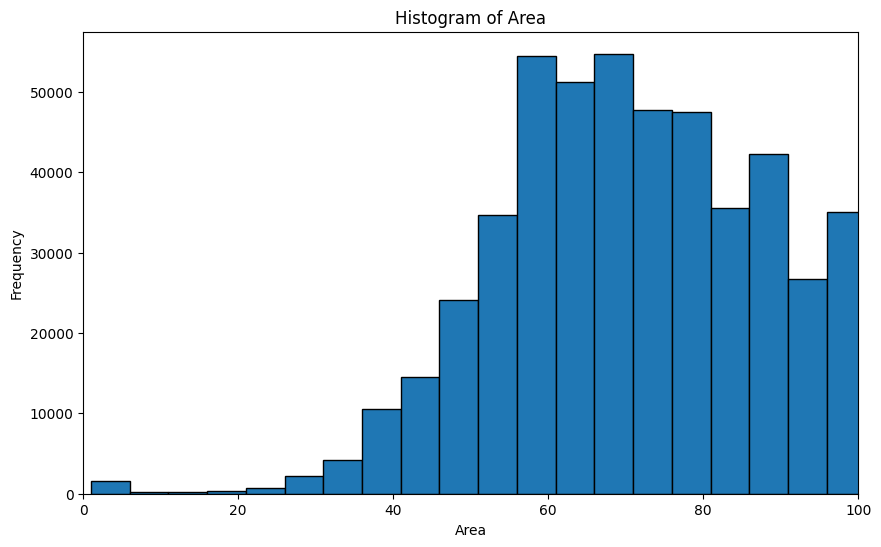

In [98]:
# Create a histogram of the 'area' column
plt.figure(figsize=(10, 6))
plt.hist(df_inmuebles['area'], bins=1000, edgecolor='black')

# Set the x-axis limits
plt.xlim(0, 100)  # Set xlim to desired values

# Add titles and labels
plt.title('Histogram of Area')
plt.xlabel('Area')
plt.ylabel('Frequency')

# Display the plot
plt.show()


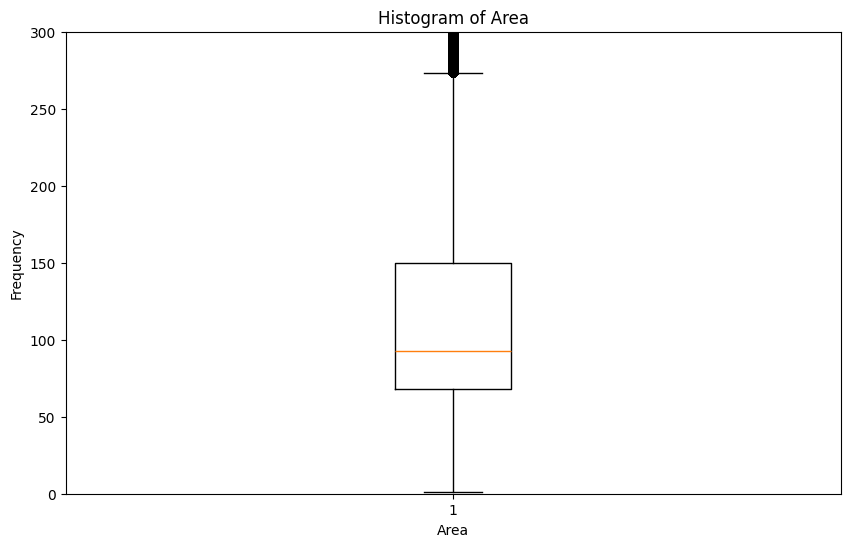

In [99]:
# Create a histogram of the 'area' column
plt.figure(figsize=(10, 6))
plt.boxplot(df_inmuebles['area'])

# Set the x-axis limits
# plt.xlim(0, 1000)  # Set xlim to desired values
plt.ylim(0, 300)
# plt.ylim(0, 50)

# Add titles and labels
plt.title('Histogram of Area')
plt.xlabel('Area')
plt.ylabel('Frequency')

# Display the plot
plt.show()


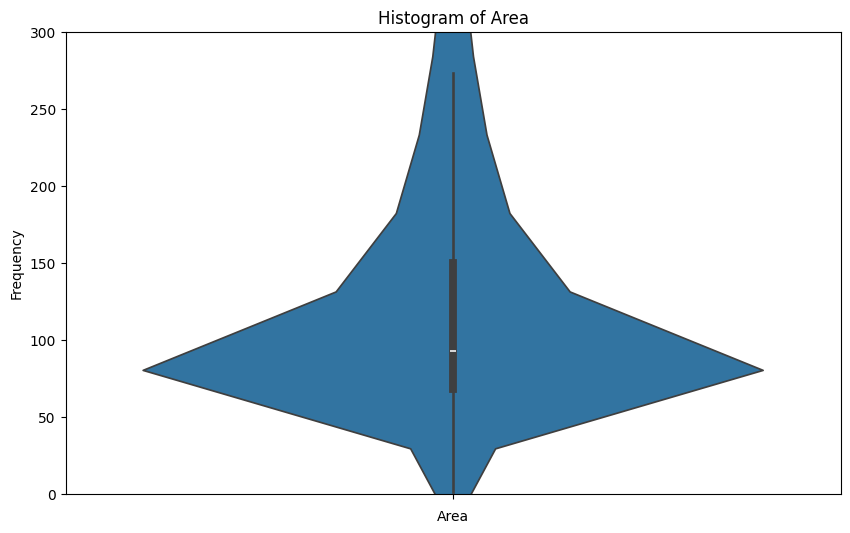

In [100]:
# Create a histogram of the 'area' column
plt.figure(figsize=(10, 6))
sns.violinplot(df_inmuebles['area'], inner='box')

# Set the x-axis limits
# plt.xlim(0, 1000)  # Set xlim to desired values
plt.ylim(0, 300)
# plt.ylim(0, 50)

# Add titles and labels
plt.title('Histogram of Area')
plt.xlabel('Area')
plt.ylabel('Frequency')

# Display the plot
plt.show()


In [101]:
Q1 = df_inmuebles['area'].quantile(0.25)
Q2 = df_inmuebles['area'].quantile(0.50)
Q3 = df_inmuebles['area'].quantile(0.75)

# Calculate IQR
IQR = Q3 - Q1

# Calculate the lower and upper whiskers
lower_whisker = Q1 - 1.5 * IQR
upper_whisker = Q3 + 1.5 * IQR

print(f"Q1 (25th percentile): {Q1}")
print(f"Median (50th percentile): {Q2}")
print(f"Q3 (75th percentile): {Q3}")
print(f"IQR (Interquartile Range): {IQR}")
print(f"Lower Whisker: {lower_whisker}")
print(f"Upper Whisker: {upper_whisker}")

Q1 (25th percentile): 68.0
Median (50th percentile): 93.0
Q3 (75th percentile): 150.0
IQR (Interquartile Range): 82.0
Lower Whisker: -55.0
Upper Whisker: 273.0


In [102]:
df_inmuebles['area'].describe()

count    882888.000000
mean        135.641558
std         176.146918
min           1.000000
25%          68.000000
50%          93.000000
75%         150.000000
max        4998.000000
Name: area, dtype: float64

In [103]:
df_inmuebles[df_inmuebles['codigo_upl'] == 'UPL30'].sort_values(by='precio_m2', ascending=False).head(50)
# ['precio'].hist()

,id,fecha_creacion,departamento,municipio,habitaciones,banos,area,precio,num_ascensores,garajes,direccion,anos_antiguedad,tipo_inmueble,tiponegocio,geometry,index_right,codigo_upl,precio_m2
850834,3492038,2022-01-27,"BOGOTÁ, D.C.","BOGOTÁ, D.C.",3.0,2,90.0,2.500000e+13,1,1,CALLE 24B BIS 69A- 55,12,apartamento,arriendo,POINT (-74.11063 4.65716),1.0,UPL30,277777.796667
227988,3213542,2021-12-12,"BOGOTÁ, D.C.","BOGOTÁ, D.C.",3.0,2,90.0,2.500000e+13,1,1,CALLE 24B BIS 69A- 55,12,apartamento,arriendo,POINT (-74.11063 4.65716),1.0,UPL30,277777.796667
383697,2584815,2021-10-22,"BOGOTÁ, D.C.","BOGOTÁ, D.C.",3.0,2,90.0,2.500000e+13,1,1,CALLE 24B BIS 69A- 55,12,apartamento,arriendo,POINT (-74.11063 4.65716),1.0,UPL30,277777.796667
122394,4674336,2022-06-22,"BOGOTÁ, D.C.","BOGOTÁ, D.C.",3.0,3,2.0,1.391392e+09,1,2,"Calle 26 #70 a -45, Ciudad Salitre, Zona Occid...",4,apartamento,venta,POINT (-74.11079 4.66554),1.0,UPL30,695.696114
590850,4323569,2022-05-03,"BOGOTÁ, D.C.","BOGOTÁ, D.C.",3.0,4,4.0,1.010000e+09,0,2,salitre,4,apartamento,venta,POINT (-74.10905 4.64932),1.0,UPL30,252.500000
123939,3896526,2022-03-17,"BOGOTÁ, D.C.","BOGOTÁ, D.C.",3.0,4,4.0,1.010000e+09,0,2,salitre,4,apartamento,venta,POINT (-74.10905 4.64932),1.0,UPL30,252.500000
694845,3664834,2022-03-02,"BOGOTÁ, D.C.","BOGOTÁ, D.C.",3.0,4,4.0,1.010000e+09,0,2,salitre,4,apartamento,venta,POINT (-74.10905 4.64932),1.0,UPL30,252.500000
383954,4369018,2022-05-03,"BOGOTÁ, D.C.","BOGOTÁ, D.C.",6.0,4,4.0,1.000000e+09,0,2,Crr 81d 24d 69,30,casa,venta,POINT (-74.11533 4.66402),1.0,UPL30,250.000000
695181,3939837,2022-03-18,"BOGOTÁ, D.C.","BOGOTÁ, D.C.",6.0,4,4.0,1.000000e+09,0,2,Crr 81d 24d 69,30,casa,venta,POINT (-74.11533 4.66402),1.0,UPL30,250.000000
589436,4761396,2022-07-16,"BOGOTÁ, D.C.","BOGOTÁ, D.C.",3.0,2,3.0,3.900000e+08,0,1,CL 54 BIS 71C 28,23,apartamento,venta,POINT (-74.10532 4.67185),1.0,UPL30,130.000000


### Primera Versión

Para la primera iteración, se calcula simplemente el precio promedio del metro cuadrado de los inmuebles dentro de esa UPL

In [104]:
df_precio_upl = df_inmuebles.groupby(['codigo_upl']).agg(
    mean_precio = ('precio', 'mean'),
    median_precio = ('precio', 'median'),
    mean_precio_m2 = ('precio_m2', 'mean'),
    median_precio_m2 = ('precio_m2', 'median'),
    mean_area = ('area', 'mean'),
    median_area = ('area', 'median'),
    count = ('id', 'count')
).reset_index().sort_values(by='mean_precio_m2', ascending=False)

df_precio_upl['mean_precio'] = df_precio_upl['mean_precio'] / 1000000
df_precio_upl['median_precio'] = df_precio_upl['median_precio'] / 1000000

# Complete the information of the UPL to graph it
df_precio_upl =pd.merge(
    df_precio_upl,
    df_upls,
    how='left',
    on='codigo_upl'
)

# Convert to geodataframe
df_precio_upl = gpd.GeoDataFrame(
    df_precio_upl,
    geometry='geometry'
)

In [105]:
df_precio_upl.head()

,codigo_upl,mean_precio,median_precio,mean_precio_m2,median_precio_m2,mean_area,median_area,count,nombre,vocacion,sector,geometry
0,UPL30,5414.040945,350.0,59.555290,4.347222,112.130374,80.0,15419,Salitre,Urbano,Sector Occidente,"POLYGON ((-74.09471 4.66478, -74.10058 4.65718..."
1,UPL24,768.622457,520.0,4.922299,5.909091,142.817761,118.0,61630,Chapinero,Urbano,Sector Centro Ampliado,"POLYGON ((-74.05651 4.64143, -74.05650 4.64143..."
2,UPL25,560.276121,450.0,4.392890,5.000000,123.654546,99.0,104775,Usaquén,Urbano,Sector Norte,"POLYGON ((-74.02093 4.72971, -74.02106 4.72966..."
3,UPL06,882.334452,462.5,4.257448,4.583152,226.986425,130.0,1326,Cerros Orientales,Rural,Sector Rural,"POLYGON ((-74.03007 4.82343, -74.02982 4.82316..."
4,UPL02,515.664063,262.0,3.943815,3.054985,121.280992,93.0,121,Cuenca del Tunjuelo,Rural,Sector Rural,"POLYGON ((-74.08522 4.48832, -74.08529 4.48828..."


<Axes: >

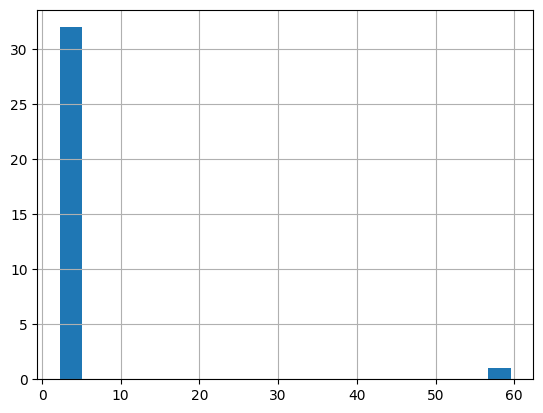

In [106]:
df_precio_upl['mean_precio_m2'].hist(bins=20)

<Axes: >

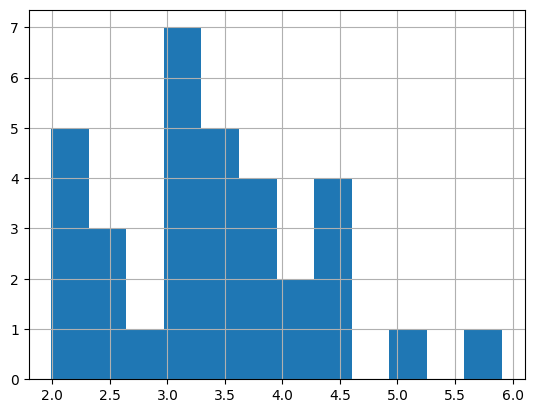

In [107]:
df_precio_upl['median_precio_m2'].hist(bins=12)

Sin embargo, al revisar los resultados de la agrupación existe una zona particular (UPL 30) donde el promedio del precio del metro cuadrado es demasiado elevado (ver el histograma), ubicandose cerca de los 60 millones de pesos colombianos por metro cuadrado, mientras que las demás UPLs no sobrepasan los 10 millones de pesos colombianos por metro cuadrado.

Además de la gráfica, otras razones que explican la situación de esta UPL:

1. Valor de la mediana extremadamente lejano al precio promedio y similar al de las demás UPLs. Dado que el promedio es sensible a outliers, pueden existir valores atípicos que eleven el promedio. La mediana puede ser un mejor estimador del precio del metro cuadrado de los inmuebles por UPL.
1. Más allá de los datos, visto desde un punto de vista de negocio o del sector inmobiliario en Bogotá, en Los Rosales, una de las zonas más exclusivas de Bogotá el precio del metro cuadrado en promedio se ubica en 8 millones de pesos colombianos (Fuente: [Habi.co - Habimetro](https://habi.co/habimetro/apartamentos/venta/bogota/los-rosales)). Por lo que el valor del precio promedio por metro cuadrado en esta UPL es totalmente erroneo desde un punto de vista lógico.

### Segunda Versión

Para esta segunda versión, se implementará la **I de Moran** a partir de la mediana del precio del metro cuadrado por UPL

In [108]:
w = Queen.from_dataframe(
    df=df_precio_upl, 
    geom_col='geometry',
    use_index=False
)
# w.transform = 'r'
y = df_precio_upl['median_precio_m2']

In [109]:
moran = Moran(
    y=y, 
    w=w
)

In [110]:
moran.I

0.5590249488846526

In [111]:
moran.p_sim

0.001

c:\Users\SGM\Documents\Habi\Prueba Data Science\venv\lib\site-packages\splot\_viz_esda_mpl.py:354: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.




(<Figure size 1000x400 with 2 Axes>,
 array([<Axes: title={'center': 'Reference Distribution'}, xlabel='Moran I: 0.56', ylabel='Density'>,
        <Axes: title={'center': 'Moran Scatterplot (0.56)'}, xlabel='Attribute', ylabel='Spatial Lag'>],
       dtype=object))

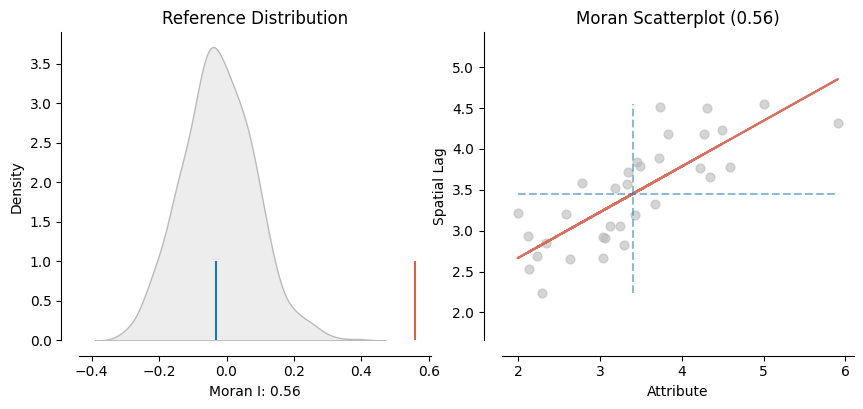

In [112]:
plot_moran(moran, zstandard=False, figsize=(10,4))

In [113]:
moran_local = Moran_Local(
    y=y,
    w=w
)

In [114]:
df_precio_upl['p_sim'] = moran_local.p_sim
df_precio_upl['q'] = moran_local.q
df_precio_upl.loc[df_precio_upl['q'] == 1, 'tipo'] = 'HH'
df_precio_upl.loc[df_precio_upl['q'] == 2, 'tipo'] = 'LH'
df_precio_upl.loc[df_precio_upl['q'] == 3, 'tipo'] = 'LL'
df_precio_upl.loc[df_precio_upl['q'] == 4, 'tipo'] = 'HL'
df_precio_upl['significativo'] = 0
df_precio_upl.loc[df_precio_upl['p_sim'] <= 0.05, 'significativo'] = 1

(<Figure size 700x700 with 1 Axes>,
 <Axes: title={'center': 'Moran Local Scatterplot'}, xlabel='Attribute', ylabel='Spatial Lag'>)

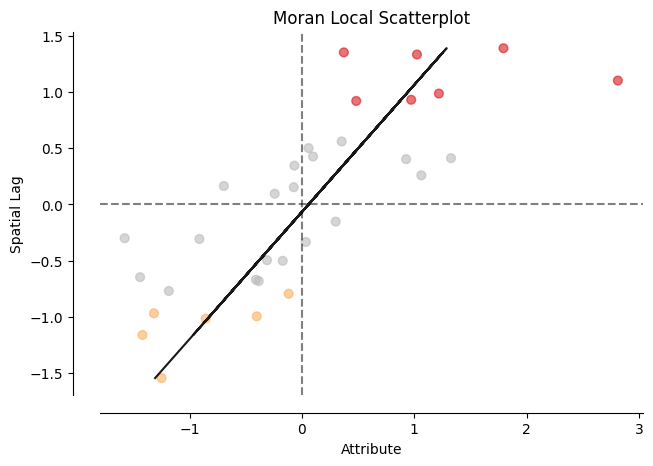

In [115]:
moran_scatterplot(moran_local, p=0.05)

(<Figure size 500x500 with 1 Axes>, <Axes: >)

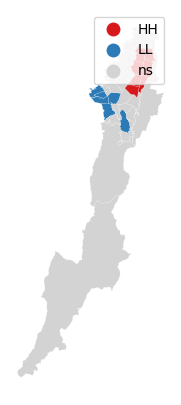

In [116]:
lisa_cluster(
    moran_loc=moran_local,
    gdf=df_precio_upl,
    p=0.05,
    figsize=(5, 5),
)

In [57]:
df_precio_upl.head()

,codigo_upl,mean_precio,median_precio,mean_precio_m2,median_precio_m2,mean_area,median_area,count,nombre,vocacion,sector,geometry,p_sim,q,significativo,tipo
0,UPL30,5414.040945,350.0,59.555290,4.347222,112.130374,80.0,15419,Salitre,Urbano,Sector Occidente,"POLYGON ((-74.09471 4.66478, -74.10058 4.65718...",0.187,1,0,HH
1,UPL24,768.622457,520.0,4.922299,5.909091,142.817761,118.0,61630,Chapinero,Urbano,Sector Centro Ampliado,"POLYGON ((-74.05651 4.64143, -74.05650 4.64143...",0.001,1,1,HH
2,UPL25,560.276121,450.0,4.392890,5.000000,123.654546,99.0,104775,Usaquén,Urbano,Sector Norte,"POLYGON ((-74.02093 4.72971, -74.02106 4.72966...",0.001,1,1,HH
3,UPL06,882.334452,462.5,4.257448,4.583152,226.986425,130.0,1326,Cerros Orientales,Rural,Sector Rural,"POLYGON ((-74.03007 4.82343, -74.02982 4.82316...",0.069,1,0,HH
4,UPL02,515.664063,262.0,3.943815,3.054985,121.280992,93.0,121,Cuenca del Tunjuelo,Rural,Sector Rural,"POLYGON ((-74.08522 4.48832, -74.08529 4.48828...",0.099,3,0,LL


In [58]:
df_precio_upl.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   codigo_upl        33 non-null     object  
 1   mean_precio       33 non-null     float64 
 2   median_precio     33 non-null     float64 
 3   mean_precio_m2    33 non-null     float64 
 4   median_precio_m2  33 non-null     float64 
 5   mean_area         33 non-null     float64 
 6   median_area       33 non-null     float64 
 7   count             33 non-null     int64   
 8   nombre            33 non-null     object  
 9   vocacion          33 non-null     object  
 10  sector            33 non-null     object  
 11  geometry          33 non-null     geometry
 12  p_sim             33 non-null     float64 
 13  q                 33 non-null     int32   
 14  significativo     33 non-null     int64   
 15  tipo              33 non-null     object  
dtypes: float64(7), geome

### Mapa

In [125]:
# Create the map object
mapa_precios_upls = KeplerGl(
    height=500,
    # data={'ofertas_upl': df_ofertas_upl}
)

# Add the data of predios per upl
mapa_precios_upls.add_data(df_precio_upl, 'Precios UPL')

# Read the config of the map as a json
# with open('Data/config_mapa_ofertas_upls.json') as file:
#     config_mapa_predios_upls = json.load(file)

# Read the config of the map as a json
config_mapa_precios_upls = json.loads(
    '{"version": "v1", "config": {"visState": {"filters": [{"dataId": ["Precios UPL"], "id": "ijnync6sy", "name": ["significativo"], "type": "range", "value": [0.027, 1], "enlarged": false, "plotType": "histogram", "animationWindow": "free", "yAxis": null, "speed": 1}], "layers": [{"id": "ahw323p", "type": "geojson", "config": {"dataId": "Precios UPL", "label": "Precios UPL", "color": [18, 147, 154], "highlightColor": [252, 242, 26, 255], "columns": {"geojson": "geometry"}, "isVisible": true, "visConfig": {"opacity": 0.8, "strokeOpacity": 0.8, "thickness": 0.5, "strokeColor": [221, 178, 124], "colorRange": {"name": "ColorBrewer RdYlBu-4", "type": "diverging", "category": "ColorBrewer", "colors": ["#d7191c", "#fdae61", "#abd9e9", "#2c7bb6"], "reversed": false}, "strokeColorRange": {"name": "Global Warming", "type": "sequential", "category": "Uber", "colors": ["#5A1846", "#900C3F", "#C70039", "#E3611C", "#F1920E", "#FFC300"]}, "radius": 10, "sizeRange": [0, 10], "radiusRange": [0, 50], "heightRange": [0, 500], "elevationScale": 5, "enableElevationZoomFactor": true, "stroked": true, "filled": true, "enable3d": false, "wireframe": false}, "hidden": false, "textLabel": [{"field": null, "color": [255, 255, 255], "size": 18, "offset": [0, 0], "anchor": "start", "alignment": "center"}]}, "visualChannels": {"colorField": {"name": "tipo", "type": "string"}, "colorScale": "ordinal", "strokeColorField": null, "strokeColorScale": "quantile", "sizeField": null, "sizeScale": "linear", "heightField": null, "heightScale": "linear", "radiusField": null, "radiusScale": "linear"}}], "interactionConfig": {"tooltip": {"fieldsToShow": {"Precios UPL": [{"name": "codigo_upl", "format": null}, {"name": "nombre", "format": null}, {"name": "median_precio_m2", "format": null}, {"name": "significativo", "format": null}, {"name": "tipo", "format": null}]}, "compareMode": false, "compareType": "absolute", "enabled": true}, "brush": {"size": 0.5, "enabled": false}, "geocoder": {"enabled": false}, "coordinate": {"enabled": false}}, "layerBlending": "normal", "splitMaps": [], "animationConfig": {"currentTime": null, "speed": 1}}, "mapState": {"bearing": 0, "dragRotate": false, "latitude": 4.6943395424111545, "longitude": -74.0203014546056, "pitch": 0, "zoom": 10.086429633870813, "isSplit": false}, "mapStyle": {"styleType": "dark", "topLayerGroups": {}, "visibleLayerGroups": {"label": true, "road": true, "border": false, "building": true, "water": true, "land": true, "3d building": false}, "threeDBuildingColor": [9.665468314072013, 17.18305478057247, 31.1442867897876], "mapStyles": {}}}}'
)

# Set the configuration to the map
mapa_precios_upls.config = config_mapa_precios_upls

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


In [126]:
mapa_precios_upls

KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [{'dataId': ['Precios UPL'], 'id': 'ijnyn…

In [122]:
# Save the config to a json file
# config_mapa_precios_upls = mapa_precios_upls.config
# with open("Data/config_mapa_precios_upls.json", "w") as outfile: 
#     json.dump(config_mapa_precios_upls, outfile)

In [127]:
# Save the map as an html
# config_mapa_precios_upls = mapa_precios_upls.config
# mapa_precios_upls.save_to_html(
#   data={
#     'Precios UPL': df_precio_upl,
#   },
#   config=config_mapa_precios_upls,
#   file_name='mapa_precios_upls.html'
# )

Map saved to mapa_precios_upls.html!


## **Punto 5**

Hacer el modelo de predicción de precios de su preferencia para valorar los inmuebles proporcionados y presentar el MAPE y RMSE del resultado.

In [ ]:
"""
Escriba aquí su código. De ser necesario, puede agregar más celdas.
"""

## **Punto 6**

Buscar y descargar base de datos de construcciones catastrales y base de datos de predios catastrales, todo con código. Es decir, utilizando las librerías necesarias para extraer datos desde internet sin necesidad de leerlos de manera local. Sugerimos la librería urllib. La información de estas fuentes la puede obtener de:

1. Construcciones catastrales: 'https://datosabiertos.bogota.gov.co/dataset/397ccbd8-e2c5-4700-b90e-b68d101ab0c5/resource/7e426e92-c168-4a99-ab67-25b16f070a68/download/dcons_geoson.zip'
2. Predios catastrales: 'https://datosabiertos.bogota.gov.co/dataset/e812efbe-acc3-4e70-9bfc-30fd2134afdd/resource/efb4e03d-173e-42b2-b35a-f10d6d610df2/download/predios_csv_1020.zip'

In [ ]:
"""
Escriba aquí su código. De ser necesario, puede agregar más celdas.
"""

### Predios + Construcciones + UPLs

#### Read Construcciones Catastrales

##### Nota:

Cada uno de los archivos se descargó y leyó únicamente con código. Sin embargo, dado que la descarga tomaba bastante tiempo con archivos superando 1 GB de memoria una vez descargados los archivos se descargaron localmente para ahorrar los tiempos de descarga y solo leer desde memoria.

A pesar de estas medidas, el código comentado en la siguiente celda es funcional y fue la manera en que se descargaron y leyeron los archivos originalmente.

In [2]:
# Time: 5 min
# # Url
# url_construcciones = 'https://datosabiertos.bogota.gov.co/dataset/397ccbd8-e2c5-4700-b90e-b68d101ab0c5/resource/7e426e92-c168-4a99-ab67-25b16f070a68/download/dcons_geoson.zip'

# # Request
# response_construcciones = urlopen(url_construcciones)

# # Check the status of the request (200 = Works)
# status_response_construcciones = response_construcciones.status
# assert(status_response_construcciones == 200)

# # Read the file
# zip_data = response_construcciones.read()
# print(type(zip_data))

# # Manage the file with an special library for .zip files
# zip_file = zipfile.ZipFile(file=io.BytesIO(zip_data))
# print(type(zip_file))
# print(zip_file.namelist())

# # Unzip the File from the .zip folder
# unzipped_file_construcciones = zip_file.open(zip_file.namelist()[0])
# print(type(unzipped_file_construcciones))

# # Read the file
# file_construcciones = unzipped_file_construcciones.read()
# print(type(file_construcciones))

# # Convert from bytes to str
# string_construcciones = file_construcciones.decode()
# print(type(string_construcciones))

# # Conver from str to dict
# dict_construcciones = json.loads(string_construcciones)
# print(type(dict_construcciones))

# # Check the type is dict so it can be accessed easily
# assert(type(dict_construcciones) == dict)

<class 'bytes'>
<class 'zipfile.ZipFile'>
<class 'zipfile.ZipExtFile'>
<class 'bytes'>
<class 'str'>
<class 'dict'>


In [2]:
# Time: 45 seconds
with open('Data/const.geojson') as file:
    dict_construcciones = json.load(file)

In [3]:
# Print the different keys in the dict and the type of value of each key
for key, value in dict_construcciones.items():
  print(f'{key}: {type(value)}')

type: <class 'str'>
name: <class 'str'>
crs: <class 'dict'>
features: <class 'list'>


In [4]:
# Create a geodataframe with the rows of the file
# Since it is a json create the dataframe with a list of dicts
list_rows = []

# The data is int the features key, where each row is a list
for row in dict_construcciones['features']:
  
  # Get the attributes (columns of the dataframe)
  attributes = row['properties']
  
  # Conver the geometry to a polygon
  geometry = row['geometry']  
  type = geometry['type']
  coordinates = geometry['coordinates']
  
  # Check the type of geometry
  if type == 'Polygon':
    polygon = Polygon(coordinates[0])
  else:
    polygon = MultiPolygon([Polygon(poly[0]) for poly in coordinates])
  
  # Add the polygon to the attributes with the key 'geometry'
  attributes['geometry'] = polygon

  # Add the dict of the row to the list of dicts
  list_rows.append(attributes)

# Clear the memory of the variable
del dict_construcciones

# Create the GeoDataFrame
df_construcciones = gpd.GeoDataFrame(
    list_rows,
    geometry='geometry'
)

# Change the column names to lowercase (just a toc)
df_construcciones.columns = [column.lower() for column in (df_construcciones.columns)]

# Keep only the columns needed
list_columns_to_keep = [
  'concodigo',
  'lotecodigo',
  'geometry',
]
df_construcciones = df_construcciones[list_columns_to_keep]
df_construcciones['concodigo'] = df_construcciones['concodigo'].str.pad(width=25, side='right', fillchar='0')
df_construcciones['cod_faltante_const'] = df_construcciones.concodigo.str[12+3:]
df_construcciones.drop_duplicates(subset='concodigo', keep='first', inplace=True)
df_construcciones.reset_index(drop=True, inplace=True)

In [6]:
df_construcciones.head()

,concodigo,lotecodigo,geometry,cod_faltante_const
0,0025480350020000000000000,002548035002,"POLYGON ((-74.11373 4.50524, -74.11372 4.50526...",0000000000
1,0092250210170000000000000,009225021017,"POLYGON ((-74.11187 4.74702, -74.11187 4.74701...",0000000000
2,0056360120130000000000000,005636012013,"POLYGON ((-74.14227 4.71458, -74.14234 4.71454...",0000000000
3,0056360740160000000000000,005636074016,"POLYGON ((-74.14249 4.71810, -74.14254 4.71807...",0000000000
4,0056360740150000000000000,005636074015,"POLYGON ((-74.14258 4.71811, -74.14258 4.71810...",0000000000


In [7]:
df_construcciones.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 565096 entries, 0 to 565095
Data columns (total 4 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   concodigo           565096 non-null  object  
 1   lotecodigo          565096 non-null  object  
 2   geometry            565096 non-null  geometry
 3   cod_faltante_const  565096 non-null  object  
dtypes: geometry(1), object(3)
memory usage: 17.2+ MB


In [8]:
df_construcciones.groupby(['cod_faltante_const']).agg(count=('concodigo', 'count')).sort_values(by='count', ascending=False)

,count
cod_faltante_const,
0000000000,565086
1000000000,3
0000000009,2
0010000000,2
2000000000,1
3000000000,1
8000000000,1


#### Read Predios Catastrales

##### Nota:

Cada uno de los archivos se descargó y leyó únicamente con código. Sin embargo, dado que la descarga tomaba bastante tiempo con archivos superando 1 GB de memoria una vez descargados los archivos se descargaron localmente para ahorrar los tiempos de descarga y solo leer desde memoria.

A pesar de estas medidas, el código comentado en la siguiente celda es funcional y fue la manera en que se descargaron y leyeron los archivos originalmente.

In [9]:
# Time: 5 min
# # Url
# url_predios = 'https://datosabiertos.bogota.gov.co/dataset/e812efbe-acc3-4e70-9bfc-30fd2134afdd/resource/efb4e03d-173e-42b2-b35a-f10d6d610df2/download/predios_csv_1020.zip'

# # Request
# response_predios = urlopen(url_predios)

# # Check the status of the request (200 = Works)
# status_response_predios = response_predios.status
# assert(status_response_predios == 200)

# # Read the file
# zip_data = response_predios.read()
# print(type(zip_data))

# # Manage the file with an special library for .zip files
# zip_file = zipfile.ZipFile(file=io.BytesIO(zip_data))
# print(type(zip_file))

# # Unzip the File from the .zip folder
# unzipped_file_predios = zip_file.open(zip_file.namelist()[0])
# print(type(unzipped_file_predios))

# # Read the file
# file_predios = unzipped_file_predios.read()
# print(type(file_predios))

# # Convert from bytes to str
# string_predios = file_predios.decode()
# print(type(string_predios))

# # 'Save' in memory the file and then read it as a traditional csv file
# csv_predios = io.StringIO(string_predios)
# df_predios = pd.read_csv(csv_predios, sep=';')
# print(type(df_predios))

# # Check the type is DataFrame
# assert(isinstance(df_predios, pd.DataFrame))

In [10]:
# Time: 45 seconds
df_predios = pd.read_csv('Data/Predios_CSV_1020.csv', sep=';')

C:\Users\SGM\AppData\Local\Temp\ipykernel_16672\3775391407.py:2: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  df_predios = pd.read_csv('Data/Predios_CSV_1020.csv', sep=';')


In [11]:
# Change the column names to lowercase (just a toc)
df_predios.columns = [column.lower() for column in (df_predios.columns)]

# Keep only the columns needed
list_columns_to_keep = [
    'objectid',
    'prenbarrio',
    'precmanz',
    'precpredio',
    'preccons',
    'precresto',
    'precedcata',
    'prenupre',
    'pretprop',
    'preclase',
    'precdestin',
    'preclcons',
    'barmanpre',
]
df_predios = df_predios[list_columns_to_keep]
df_predios['lote_codigo'] = df_predios['barmanpre'].astype(str).str.pad(width=12, side='left', fillchar='0')
df_predios['cod_cons'] = df_predios['preccons'].astype(str).str.pad(width=3, side='left', fillchar='0')
df_predios['construccion_codigo'] = (df_predios['lote_codigo'] + df_predios['cod_cons']).str.pad(width=25, side='right', fillchar='0')

In [12]:
df_predios.head()

,objectid,prenbarrio,precmanz,precpredio,preccons,precresto,precedcata,prenupre,pretprop,preclase,precdestin,preclcons,barmanpre,lote_codigo,cod_cons,construccion_codigo
0,1,BUENOS AIRES,23,2,1,1006,001102230200101006,110010111040200230002901010006,6,P,1,R,1102023002,001102023002,001,0011020230020010000000000
1,2,BUENOS AIRES,23,2,1,1007,001102230200101007,110010111040200230002901010007,6,P,1,R,1102023002,001102023002,001,0011020230020010000000000
2,3,BUENOS AIRES,23,2,1,1008,001102230200101008,110010111040200230002901010008,6,P,1,R,1102023002,001102023002,001,0011020230020010000000000
3,4,BUENOS AIRES,23,2,1,1010,001102230200101010,110010111040200230002901010010,6,P,1,R,1102023002,001102023002,001,0011020230020010000000000
4,5,BUENOS AIRES,23,2,1,1011,001102230200101011,110010111040200230002901010011,6,P,1,R,1102023002,001102023002,001,0011020230020010000000000


In [13]:
df_predios.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3511266 entries, 0 to 3511265
Data columns (total 16 columns):
 #   Column               Dtype 
---  ------               ----- 
 0   objectid             int64 
 1   prenbarrio           object
 2   precmanz             int64 
 3   precpredio           int64 
 4   preccons             int64 
 5   precresto            int64 
 6   precedcata           object
 7   prenupre             object
 8   pretprop             int64 
 9   preclase             object
 10  precdestin           int64 
 11  preclcons            object
 12  barmanpre            int64 
 13  lote_codigo          object
 14  cod_cons             object
 15  construccion_codigo  object
dtypes: int64(8), object(8)
memory usage: 428.6+ MB


#### Join Espacial

Hacer un join espacial entre la base de datos de predios y la de UPLs y calcular cuántos predios residenciales existen en Bogotá por UPL.

In [14]:
"""
Escriba aquí su código. De ser necesario, puede agregar más celdas.
"""

'\nEscriba aquí su código. De ser necesario, puede agregar más celdas.\n'

##### Predios + Construcciones + UPLs

##### Join

In [33]:
df_construcciones_upls = gpd.sjoin(
    df_construcciones,
    df_upls[['codigo_upl', 'geometry']],
    how='left',
    predicate='within'
)

In [34]:
df_construcciones_upls.head()

,concodigo,lotecodigo,geometry,cod_faltante_const,index_right,codigo_upl
0,0025480350020000000000000,002548035002,"POLYGON ((-74.11373 4.50524, -74.11372 4.50526...",0000000000,25.0,UPL05
1,0092250210170000000000000,009225021017,"POLYGON ((-74.11187 4.74702, -74.11187 4.74701...",0000000000,19.0,UPL10
2,0056360120130000000000000,005636012013,"POLYGON ((-74.14227 4.71458, -74.14234 4.71454...",0000000000,16.0,UPL11
3,0056360740160000000000000,005636074016,"POLYGON ((-74.14249 4.71810, -74.14254 4.71807...",0000000000,16.0,UPL11
4,0056360740150000000000000,005636074015,"POLYGON ((-74.14258 4.71811, -74.14258 4.71810...",0000000000,16.0,UPL11


In [35]:
df_construcciones_upls.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 565096 entries, 0 to 565095
Data columns (total 6 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   concodigo           565096 non-null  object  
 1   lotecodigo          565096 non-null  object  
 2   geometry            565096 non-null  geometry
 3   cod_faltante_const  565096 non-null  object  
 4   index_right         564763 non-null  float64 
 5   codigo_upl          564763 non-null  object  
dtypes: float64(1), geometry(1), object(4)
memory usage: 30.2+ MB


In [36]:
df_predios_join = pd.merge(
    df_predios,
    df_construcciones_upls[['concodigo', 'codigo_upl']],
    how='left',
    left_on='construccion_codigo',
    right_on='concodigo'
)

In [37]:
df_predios_join.head()

,objectid,prenbarrio,precmanz,precpredio,preccons,precresto,precedcata,prenupre,pretprop,preclase,precdestin,preclcons,barmanpre,lote_codigo,cod_cons,construccion_codigo,concodigo,codigo_upl
0,1,BUENOS AIRES,23,2,1,1006,001102230200101006,110010111040200230002901010006,6,P,1,R,1102023002,001102023002,001,0011020230020010000000000,NaN,NaN
1,2,BUENOS AIRES,23,2,1,1007,001102230200101007,110010111040200230002901010007,6,P,1,R,1102023002,001102023002,001,0011020230020010000000000,NaN,NaN
2,3,BUENOS AIRES,23,2,1,1008,001102230200101008,110010111040200230002901010008,6,P,1,R,1102023002,001102023002,001,0011020230020010000000000,NaN,NaN
3,4,BUENOS AIRES,23,2,1,1010,001102230200101010,110010111040200230002901010010,6,P,1,R,1102023002,001102023002,001,0011020230020010000000000,NaN,NaN
4,5,BUENOS AIRES,23,2,1,1011,001102230200101011,110010111040200230002901010011,6,P,1,R,1102023002,001102023002,001,0011020230020010000000000,NaN,NaN


In [38]:
df_predios_join.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3511266 entries, 0 to 3511265
Data columns (total 18 columns):
 #   Column               Dtype 
---  ------               ----- 
 0   objectid             int64 
 1   prenbarrio           object
 2   precmanz             int64 
 3   precpredio           int64 
 4   preccons             int64 
 5   precresto            int64 
 6   precedcata           object
 7   prenupre             object
 8   pretprop             int64 
 9   preclase             object
 10  precdestin           int64 
 11  preclcons            object
 12  barmanpre            int64 
 13  lote_codigo          object
 14  cod_cons             object
 15  construccion_codigo  object
 16  concodigo            object
 17  codigo_upl           object
dtypes: int64(8), object(10)
memory usage: 482.2+ MB


In [39]:
# Find the ofertas per UPL and sort it from higher to lower
df_predios_residenciales_upl = df_predios_join[df_predios_join['preclcons'] == 'R'].groupby(['codigo_upl']).agg(predios=('objectid', 'count')).reset_index().sort_values(by='predios', ascending=False)

# Find the percentage and since it is sorted the cumulative percentage to check rules as Pareto
df_predios_residenciales_upl['porcentaje'] = df_predios_residenciales_upl['predios'] / df_predios_residenciales_upl['predios'].sum()
df_predios_residenciales_upl['porcentaje_acum'] = df_predios_residenciales_upl['porcentaje'].cumsum()


# Complete the information of the UPL to graph it
df_predios_residenciales_upl = pd.merge(
    df_predios_residenciales_upl,
    df_upls,
    how='left',
    on='codigo_upl'
)

# Convert to geodataframe
df_predios_residenciales_upl = gpd.GeoDataFrame(
    df_predios_residenciales_upl,
    geometry='geometry'
)

In [40]:
df_predios_residenciales_upl.head()

,codigo_upl,predios,porcentaje,porcentaje_acum,nombre,vocacion,sector,geometry
0,UPL25,155095,0.100861,0.100861,Usaquén,Urbano,Sector Norte,"POLYGON ((-74.02093 4.72971, -74.02106 4.72966..."
1,UPL24,84615,0.055027,0.155888,Chapinero,Urbano,Sector Centro Ampliado,"POLYGON ((-74.05651 4.64143, -74.05650 4.64143..."
2,UPL27,79506,0.051704,0.207592,Niza,Urbano,Sector Norte,"POLYGON ((-74.07828 4.73386, -74.07750 4.73341..."
3,UPL08,75658,0.049202,0.256794,Britalia,Urbano-Rural,Sector Norte,"POLYGON ((-74.06328 4.77114, -74.06327 4.77114..."
4,UPL29,66546,0.043276,0.300070,Tabora,Urbano,Sector Occidente,"POLYGON ((-74.09908 4.71754, -74.09886 4.71746..."


In [41]:
df_predios_residenciales_upl.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   codigo_upl       33 non-null     object  
 1   predios          33 non-null     int64   
 2   porcentaje       33 non-null     float64 
 3   porcentaje_acum  33 non-null     float64 
 4   nombre           33 non-null     object  
 5   vocacion         33 non-null     object  
 6   sector           33 non-null     object  
 7   geometry         33 non-null     geometry
dtypes: float64(2), geometry(1), int64(1), object(4)
memory usage: 2.2+ KB


In [43]:
print(f"Predios: {'{:,}'.format(df_predios_join[(df_predios_join['preclcons'] == 'R')].shape[0])}")
print(f"Predios con UPL: {'{:,}'.format(df_predios_residenciales_upl['predios'].sum())}")

Predios: 2,818,556
Predios con UPL: 1,537,708


##### Mapa

Para añadir la dimensión geográfica al número de ofertas por UPL, es necesario verlo a través de un mapa. Esto permite analizar patrones y tendencias a traves del espacio.
1. (**Recomendado**) Visualizar la versión desplegada en página web en [este link](https://santigonzalezz.github.io/habi_prueba_data_science/mapa_predios_upls.html)
1. Visualizar el mapa en las celdas siguientes, sin embargo, se encuentra limitada la interactividad y es posible errores al guardar el archivo y no ejecutar las celdas

In [90]:
# Create the map object
mapa_predios_upls = KeplerGl(
    height=500,
    # data={'ofertas_upl': df_ofertas_upl}
)

# Add the data of predios per upl
mapa_predios_upls.add_data(df_predios_residenciales_upl, 'Predios UPL')

# Read the config of the map as a json
# with open('Data/config_mapa_ofertas_upls.json') as file:
#     config_mapa_predios_upls = json.load(file)

# Read the config of the map as a json
config_mapa_predios_upls = json.loads(
    '{"version": "v1", "config": {"visState": {"filters": [], "layers": [{"id": "y13j8b", "type": "geojson", "config": {"dataId": "Predios UPL", "label": "Predios UPL", "color": [18, 92, 119], "highlightColor": [252, 242, 26, 255], "columns": {"geojson": "geometry"}, "isVisible": true, "visConfig": {"opacity": 0.8, "strokeOpacity": 0.8, "thickness": 0.5, "strokeColor": [183, 136, 94], "colorRange": {"name": "ColorBrewer Blues-9", "type": "singlehue", "category": "ColorBrewer", "colors": ["#f7fbff", "#deebf7", "#c6dbef", "#9ecae1", "#6baed6", "#4292c6", "#2171b5", "#08519c", "#08306b"]}, "strokeColorRange": {"name": "Global Warming", "type": "sequential", "category": "Uber", "colors": ["#5A1846", "#900C3F", "#C70039", "#E3611C", "#F1920E", "#FFC300"]}, "radius": 10, "sizeRange": [0, 10], "radiusRange": [0, 50], "heightRange": [0, 500], "elevationScale": 5, "enableElevationZoomFactor": true, "stroked": true, "filled": true, "enable3d": false, "wireframe": false}, "hidden": false, "textLabel": [{"field": null, "color": [255, 255, 255], "size": 18, "offset": [0, 0], "anchor": "start", "alignment": "center"}]}, "visualChannels": {"colorField": {"name": "predios", "type": "integer"}, "colorScale": "quantile", "strokeColorField": null, "strokeColorScale": "quantile", "sizeField": null, "sizeScale": "linear", "heightField": null, "heightScale": "linear", "radiusField": null, "radiusScale": "linear"}}], "interactionConfig": {"tooltip": {"fieldsToShow": {"Predios UPL": [{"name": "codigo_upl", "format": null}, {"name": "predios", "format": null}, {"name": "porcentaje", "format": null}, {"name": "porcentaje_acum", "format": null}, {"name": "nombre", "format": null}]}, "compareMode": false, "compareType": "absolute", "enabled": true}, "brush": {"size": 0.5, "enabled": false}, "geocoder": {"enabled": false}, "coordinate": {"enabled": false}}, "layerBlending": "normal", "splitMaps": [], "animationConfig": {"currentTime": null, "speed": 1}}, "mapState": {"bearing": 0, "dragRotate": false, "latitude": 4.283904718300249, "longitude": -74.21815690262335, "pitch": 0, "zoom": 8, "isSplit": false}, "mapStyle": {"styleType": "dark", "topLayerGroups": {}, "visibleLayerGroups": {"label": true, "road": true, "border": false, "building": true, "water": true, "land": true, "3d building": false}, "threeDBuildingColor": [9.665468314072013, 17.18305478057247, 31.1442867897876], "mapStyles": {}}}}'
)

# Set the configuration to the map
mapa_predios_upls.config = config_mapa_predios_upls

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


In [92]:
# mapa_predios_upls

In [88]:
# Save the config to a json file
# config_mapa_predios_upls = mapa_predios_upls.config
# with open("Data/config_mapa_predios_upls.json", "w") as outfile: 
#     json.dump(config_mapa_predios_upls, outfile)

In [89]:
# Save the map as an html
# config_mapa_predios_upls = mapa_predios_upls.config
# mapa_predios_upls.save_to_html(
#   data={
#     'Predios UPL': df_predios_residenciales_upl,
#   },
#   config=config_mapa_predios_upls,
#   file_name='mapa_predios_upls.html'
# )

Map saved to mapa_predios_upls.html!


### Predios + Lotes + UPLs

#### Read Lotes Catastrales

##### Nota:

Cada uno de los archivos se descargó y leyó únicamente con código. Sin embargo, dado que la descarga tomaba bastante tiempo con archivos superando 1 GB de memoria una vez descargados los archivos se descargaron localmente para ahorrar los tiempos de descarga y solo leer desde memoria.

A pesar de estas medidas, el código comentado en la siguiente celda es funcional y fue la manera en que se descargaron y leyeron los archivos originalmente.

In [11]:
# Time: 12 min
# # Url
# url_lotes = 'https://datosabiertos.bogota.gov.co/dataset/f615a894-3460-4a86-ae9e-fa6e6bf35e77/resource/1bcd3890-c4f8-4859-ba71-a84667a4ee0f/download/lote.geojson.0424.zip'

# # Request
# response_lotes = urlopen(url_lotes)

# # Check the status of the request (200 = Works)
# status_response_lotes = response_lotes.status
# assert(status_response_lotes == 200)

# # Read the file
# zip_data = response_lotes.read()
# print(type(zip_data))

# # Manage the file with an special library for .zip files
# zip_file = zipfile.ZipFile(file=io.BytesIO(zip_data))
# print(type(zip_file))
# print(zip_file.namelist())

# # Unzip the File from the .zip folder
# unzipped_file_lotes = zip_file.open(zip_file.namelist()[0])
# print(type(unzipped_file_lotes))

# # Read the file
# file_lotes = unzipped_file_lotes.read()
# print(type(file_lotes))

# # Convert from bytes to str
# string_lotes = file_lotes.decode()
# print(type(string_lotes))

# # Conver from str to dict
# dict_lotes = json.loads(string_lotes)
# print(type(dict_lotes))

# # Check the type is dict so it can be accessed easily
# assert(type(dict_lotes) == dict)

<class 'bytes'>
<class 'zipfile.ZipFile'>
<class 'zipfile.ZipExtFile'>
<class 'bytes'>
<class 'str'>
<class 'dict'>


In [44]:
# Time: 45 seconds
with open('Data/lote.geojson') as file:
    dict_lotes = json.load(file)

In [8]:
# Print the different keys in the dict and the type of value of each key
for key, value in dict_lotes.items():
  print(f'{key}: {type(value)}')

type: <class 'str'>
name: <class 'str'>
crs: <class 'dict'>
features: <class 'list'>


In [45]:
# Create a geodataframe with the rows of the file
# Since it is a json create the dataframe with a list of dicts
list_rows = []

# The data is int the features key, where each row is a list
for row in dict_lotes['features']:
  
  # Get the attributes (columns of the dataframe)
  attributes = row['properties']
  
  # Conver the geometry to a polygon
  geometry = row['geometry']  
  type = geometry['type']
  coordinates = geometry['coordinates']
  
  # Check the type of geometry
  if type == 'Polygon':
    polygon = Polygon(coordinates[0])
  else:
    polygon = MultiPolygon([Polygon(poly[0]) for poly in coordinates])
  
  # Add the polygon to the attributes with the key 'geometry'
  attributes['geometry'] = polygon

  # Add the dict of the row to the list of dicts
  list_rows.append(attributes)
  
# Clear the memory of the variable
del dict_lotes
  
# Create the GeoDataFrame
df_lotes = gpd.GeoDataFrame(
    list_rows,
    geometry='geometry'
)

# Change the column names to lowercase (just a toc)
df_lotes.columns = [column.lower() for column in (df_lotes.columns)]

# Keep only the columns needed
list_columns_to_keep = [
  'lotcodigo',
  'lotupredia',
  'geometry',
]
df_lotes = df_lotes[list_columns_to_keep]

In [46]:
df_lotes.head()

,lotcodigo,lotupredia,geometry
0,002445050010,1,"POLYGON ((-74.16910 4.57265, -74.16910 4.57265..."
1,002528010061,1,"POLYGON ((-74.11461 4.51709, -74.11466 4.51708..."
2,002445050018,1,"POLYGON ((-74.16899 4.57266, -74.16901 4.57261..."
3,002445079020,1,"POLYGON ((-74.17524 4.57270, -74.17519 4.57269..."
4,009136013012,1,"POLYGON ((-74.04231 4.80056, -74.04232 4.80053..."


In [47]:
df_lotes.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 931993 entries, 0 to 931992
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   lotcodigo   931979 non-null  object  
 1   lotupredia  931993 non-null  int64   
 2   geometry    931993 non-null  geometry
dtypes: geometry(1), int64(1), object(1)
memory usage: 21.3+ MB


#### Predios + Lotes + UPLs

##### Join

In [48]:
df_lotes_upls = gpd.sjoin(
    df_lotes,
    df_upls[['codigo_upl', 'geometry']],
    how='left',
    predicate='within'
)

In [49]:
df_lotes_upls.head()

,lotcodigo,lotupredia,geometry,index_right,codigo_upl
0,002445050010,1,"POLYGON ((-74.16910 4.57265, -74.16910 4.57265...",14.0,UPL03
1,002528010061,1,"POLYGON ((-74.11461 4.51709, -74.11466 4.51708...",26.0,UPL20
2,002445050018,1,"POLYGON ((-74.16899 4.57266, -74.16901 4.57261...",14.0,UPL03
3,002445079020,1,"POLYGON ((-74.17524 4.57270, -74.17519 4.57269...",14.0,UPL03
4,009136013012,1,"POLYGON ((-74.04231 4.80056, -74.04232 4.80053...",22.0,UPL07


In [50]:
df_lotes_upls.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 931993 entries, 0 to 931992
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype   
---  ------       --------------   -----   
 0   lotcodigo    931979 non-null  object  
 1   lotupredia   931993 non-null  int64   
 2   geometry     931993 non-null  geometry
 3   index_right  928468 non-null  float64 
 4   codigo_upl   928468 non-null  object  
dtypes: float64(1), geometry(1), int64(1), object(2)
memory usage: 42.7+ MB


In [51]:
df_predios_lotes_upls = pd.merge(
    df_predios,
    df_lotes_upls[['lotcodigo', 'codigo_upl']],
    how='left',
    left_on='lote_codigo',
    right_on='lotcodigo'
)

In [52]:
df_predios_lotes_upls.head()

,objectid,prenbarrio,precmanz,precpredio,preccons,precresto,precedcata,prenupre,pretprop,preclase,precdestin,preclcons,barmanpre,lote_codigo,cod_cons,construccion_codigo,lotcodigo,codigo_upl
0,1,BUENOS AIRES,23,2,1,1006,001102230200101006,110010111040200230002901010006,6,P,1,R,1102023002,001102023002,001,0011020230020010000000000,001102023002,UPL21
1,2,BUENOS AIRES,23,2,1,1007,001102230200101007,110010111040200230002901010007,6,P,1,R,1102023002,001102023002,001,0011020230020010000000000,001102023002,UPL21
2,3,BUENOS AIRES,23,2,1,1008,001102230200101008,110010111040200230002901010008,6,P,1,R,1102023002,001102023002,001,0011020230020010000000000,001102023002,UPL21
3,4,BUENOS AIRES,23,2,1,1010,001102230200101010,110010111040200230002901010010,6,P,1,R,1102023002,001102023002,001,0011020230020010000000000,001102023002,UPL21
4,5,BUENOS AIRES,23,2,1,1011,001102230200101011,110010111040200230002901010011,6,P,1,R,1102023002,001102023002,001,0011020230020010000000000,001102023002,UPL21


In [53]:
df_predios_lotes_upls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3511443 entries, 0 to 3511442
Data columns (total 18 columns):
 #   Column               Dtype 
---  ------               ----- 
 0   objectid             int64 
 1   prenbarrio           object
 2   precmanz             int64 
 3   precpredio           int64 
 4   preccons             int64 
 5   precresto            int64 
 6   precedcata           object
 7   prenupre             object
 8   pretprop             int64 
 9   preclase             object
 10  precdestin           int64 
 11  preclcons            object
 12  barmanpre            int64 
 13  lote_codigo          object
 14  cod_cons             object
 15  construccion_codigo  object
 16  lotcodigo            object
 17  codigo_upl           object
dtypes: int64(8), object(10)
memory usage: 482.2+ MB


In [54]:
# Find the ofertas per UPL and sort it from higher to lower
df_predios_residenciales_upl_lotes = df_predios_lotes_upls[df_predios_lotes_upls['preclcons'] == 'R'].groupby(['codigo_upl']).agg(predios=('objectid', 'count')).reset_index().sort_values(by='predios', ascending=False)

# Find the percentage and since it is sorted the cumulative percentage to check rules as Pareto
df_predios_residenciales_upl_lotes['porcentaje'] = df_predios_residenciales_upl_lotes['predios'] / df_predios_residenciales_upl_lotes['predios'].sum()
df_predios_residenciales_upl_lotes['porcentaje_acum'] = df_predios_residenciales_upl_lotes['porcentaje'].cumsum()


# Complete the information of the UPL to graph it
df_predios_residenciales_upl_lotes = pd.merge(
    df_predios_residenciales_upl_lotes,
    df_upls,
    how='left',
    on='codigo_upl'
)

# Convert to geodataframe
df_predios_residenciales_upl_lotes = gpd.GeoDataFrame(
    df_predios_residenciales_upl_lotes,
    geometry='geometry'
)

In [55]:
df_predios_residenciales_upl_lotes.head()

,codigo_upl,predios,porcentaje,porcentaje_acum,nombre,vocacion,sector,geometry
0,UPL25,231225,0.082585,0.082585,Usaquén,Urbano,Sector Norte,"POLYGON ((-74.02093 4.72971, -74.02106 4.72966..."
1,UPL08,158250,0.056521,0.139105,Britalia,Urbano-Rural,Sector Norte,"POLYGON ((-74.06328 4.77114, -74.06327 4.77114..."
2,UPL27,137208,0.049005,0.188111,Niza,Urbano,Sector Norte,"POLYGON ((-74.07828 4.73386, -74.07750 4.73341..."
3,UPL11,131471,0.046956,0.235067,Engativá,Urbano-Rural,Sector Occidente,"POLYGON ((-74.11900 4.73641, -74.11865 4.73630..."
4,UPL24,119432,0.042656,0.277724,Chapinero,Urbano,Sector Centro Ampliado,"POLYGON ((-74.05651 4.64143, -74.05650 4.64143..."


In [56]:
df_predios_residenciales_upl_lotes.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   codigo_upl       33 non-null     object  
 1   predios          33 non-null     int64   
 2   porcentaje       33 non-null     float64 
 3   porcentaje_acum  33 non-null     float64 
 4   nombre           33 non-null     object  
 5   vocacion         33 non-null     object  
 6   sector           33 non-null     object  
 7   geometry         33 non-null     geometry
dtypes: float64(2), geometry(1), int64(1), object(4)
memory usage: 2.2+ KB


In [57]:
print(f"Predios: {'{:,}'.format(df_predios_lotes_upls[(df_predios_lotes_upls['preclcons'] == 'R')].shape[0])}")
print(f"Predios con UPL: {'{:,}'.format(df_predios_residenciales_upl_lotes['predios'].sum())}")

Predios: 2,818,725
Predios con UPL: 2,799,856


##### Mapa

Para añadir la dimensión geográfica al número de ofertas por UPL, es necesario verlo a través de un mapa. Esto permite analizar patrones y tendencias a traves del espacio.
1. (**Recomendado**) Visualizar la versión desplegada en página web en [este link](https://santigonzalezz.github.io/habi_prueba_data_science/mapa_predios_lotes_upls.html)
1. Visualizar el mapa en las celdas siguientes, sin embargo, se encuentra limitada la interactividad y es posible errores al guardar el archivo y no ejecutar las celdas

In [44]:
# Create the map object
mapa_predios_upls_lotes = KeplerGl(
    height=500,
    # data={'ofertas_upl': df_ofertas_upl}
)

# Add the data of predios per upl
mapa_predios_upls_lotes.add_data(df_predios_residenciales_upl_lotes, 'Predios UPL')

# Read the config of the map as a json
# with open('Data/config_mapa_ofertas_upls.json') as file:
#     config_mapa_predios_upls = json.load(file)

# Read the config of the map as a json
config_mapa_predios_upls = json.loads(
    '{"version": "v1", "config": {"visState": {"filters": [], "layers": [{"id": "y13j8b", "type": "geojson", "config": {"dataId": "Predios UPL", "label": "Predios UPL", "color": [18, 92, 119], "highlightColor": [252, 242, 26, 255], "columns": {"geojson": "geometry"}, "isVisible": true, "visConfig": {"opacity": 0.8, "strokeOpacity": 0.8, "thickness": 0.5, "strokeColor": [183, 136, 94], "colorRange": {"name": "ColorBrewer Blues-9", "type": "singlehue", "category": "ColorBrewer", "colors": ["#f7fbff", "#deebf7", "#c6dbef", "#9ecae1", "#6baed6", "#4292c6", "#2171b5", "#08519c", "#08306b"]}, "strokeColorRange": {"name": "Global Warming", "type": "sequential", "category": "Uber", "colors": ["#5A1846", "#900C3F", "#C70039", "#E3611C", "#F1920E", "#FFC300"]}, "radius": 10, "sizeRange": [0, 10], "radiusRange": [0, 50], "heightRange": [0, 500], "elevationScale": 5, "enableElevationZoomFactor": true, "stroked": true, "filled": true, "enable3d": false, "wireframe": false}, "hidden": false, "textLabel": [{"field": null, "color": [255, 255, 255], "size": 18, "offset": [0, 0], "anchor": "start", "alignment": "center"}]}, "visualChannels": {"colorField": {"name": "predios", "type": "integer"}, "colorScale": "quantile", "strokeColorField": null, "strokeColorScale": "quantile", "sizeField": null, "sizeScale": "linear", "heightField": null, "heightScale": "linear", "radiusField": null, "radiusScale": "linear"}}], "interactionConfig": {"tooltip": {"fieldsToShow": {"Predios UPL": [{"name": "codigo_upl", "format": null}, {"name": "predios", "format": null}, {"name": "porcentaje", "format": null}, {"name": "porcentaje_acum", "format": null}, {"name": "nombre", "format": null}]}, "compareMode": false, "compareType": "absolute", "enabled": true}, "brush": {"size": 0.5, "enabled": false}, "geocoder": {"enabled": false}, "coordinate": {"enabled": false}}, "layerBlending": "normal", "splitMaps": [], "animationConfig": {"currentTime": null, "speed": 1}}, "mapState": {"bearing": 0, "dragRotate": false, "latitude": 4.283904718300249, "longitude": -74.21815690262335, "pitch": 0, "zoom": 8, "isSplit": false}, "mapStyle": {"styleType": "dark", "topLayerGroups": {}, "visibleLayerGroups": {"label": true, "road": true, "border": false, "building": true, "water": true, "land": true, "3d building": false}, "threeDBuildingColor": [9.665468314072013, 17.18305478057247, 31.1442867897876], "mapStyles": {}}}}'
)

# Set the configuration to the map
mapa_predios_upls_lotes.config = config_mapa_predios_upls

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


In [47]:
# mapa_predios_upls_lotes

In [ ]:
# Save the config to a json file
# config_mapa_predios_upls = mapa_predios_upls.config
# with open("Data/config_mapa_predios_upls.json", "w") as outfile: 
#     json.dump(config_mapa_predios_upls, outfile)

In [46]:
# Save the map as an html
# config_mapa_predios_upls = mapa_predios_upls_lotes.config
# mapa_predios_upls_lotes.save_to_html(
#   data={
#     'Predios UPL': df_predios_residenciales_upl_lotes,
#   },
#   config=config_mapa_predios_upls,
#   file_name='mapa_predios_lotes_upls.html'
# )

Map saved to mapa_predios_lotes_upls.html!
